### File Explanation

**trainRNN_HBTRC_ANM_EncoderModel.ipynb:**
<br> This notebook is to load AddNeuroMed examples from 'preprocessData.pickle', and HBTRC examples from 'preprocessData_HBTRC.pickle' and create an "Encoder Network". Train the network on HBTRC data set and test on AddNeuroMed data set

**Variables information**:
<br> 1) Variables in the format of xxx_A represents data from AddNeuroMed
<br> 2) Variables in the format of xxx_H represents data from HBTRC

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData.pickle' and 'preprocessData_HBTRC.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model (function: **dynamicLSTM** using **length** in **trainRNN_network_utils.py**)
<br> 5) Create a single output by using the relevants outputs of encoder models of gene A and gene B 
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 8) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 9) Plot results with **plot_one_input** in **trainRNN_plot_utils.py**)
<br> 10) Save them in "resultsEncoder_HBTRC_ANM.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of (dropout)
<br> 2) **testLosses**: Test losses, dictionary, keys of (dropout)
<br> 3) **F1_scores**: F1_scores, dictionary, keys of (dropout)
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of (dropout)

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [1]:
# LOAD AddNeuroMed DATA
# Load data form the pickle produced by "preprocessData.ipynb" in AddNeuroMed folder

# Save data into Python file
import pickle
with open('../AddNeuroMed/preprocessData.pickle', 'rb') as f:
    rSnpA_nXSN_A = pickle.load( f )
    rSnpB_nXSN_A = pickle.load( f )
    rRnaA_nXS_A = pickle.load( f )
    rRnaB_nXS_A = pickle.load( f )
    rRelated_nXC_A = pickle.load( f )
    rSnpA_tr_nXSN_A = pickle.load( f )
    rSnpB_tr_nXSN_A = pickle.load( f )
    rRnaA_tr_nXS_A = pickle.load( f )
    rRnaB_tr_nXS_A = pickle.load( f )
    rRelated_tr_nXC_A = pickle.load( f )
    rSnpA_tst_nXSN_A = pickle.load( f )
    rSnpB_tst_nXSN_A = pickle.load( f )
    rRnaA_tst_nXS_A = pickle.load( f )
    rRnaB_tst_nXS_A = pickle.load( f )
    rRelated_tst_nXC_A = pickle.load( f )
    sGeneNames_nX2_A = pickle.load( f )
    nRs_A = pickle.load( f )
    nSs_A = pickle.load( f )
    print( 'AddNeuroMed data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN_A.shape ) == 3 )
assert( len( rSnpB_nXSN_A.shape ) == 3 )
assert( len( rRnaA_nXS_A.shape ) == 2 )
assert( len( rRnaB_nXS_A.shape ) == 2)
assert( len( rRelated_nXC_A.shape ) == 2 )
assert( len( rSnpA_tr_nXSN_A.shape ) == 3 )
assert( len( rSnpB_tr_nXSN_A.shape ) == 3 )
assert( len( rRnaA_tr_nXS_A.shape ) == 2 )
assert( len( rRnaB_tr_nXS_A.shape ) == 2 )
assert( len( rRelated_tr_nXC_A.shape ) == 2 )
assert( len( rSnpA_tst_nXSN_A.shape ) == 3 )
assert( len( rSnpB_tst_nXSN_A.shape ) == 3 )
assert( len( rRnaA_tst_nXS_A.shape ) == 2 )
assert( len( rRnaB_tst_nXS_A.shape ) == 2 )
assert( len( rRelated_tst_nXC_A.shape ) == 2)
assert( rSnpA_nXSN_A.shape[ 0 ] == rRnaA_nXS_A.shape[0] )
assert( rSnpA_nXSN_A.shape[ 0 ] == rRnaB_nXS_A.shape[0] )
assert( rSnpB_nXSN_A.shape[ 0 ] == rRnaA_nXS_A.shape[0] )
assert( rSnpB_nXSN_A.shape[ 0 ] == rRnaB_nXS_A.shape[0] )
assert( rSnpA_nXSN_A.shape[ 0 ] == rRelated_nXC_A.shape[ 0 ] )
assert( rSnpA_nXSN_A.shape[ 1 ] == rRnaA_nXS_A.shape[ 1 ] )
assert( rSnpB_nXSN_A.shape[ 1 ] == rRnaB_nXS_A.shape[ 1 ] )
assert( rRelated_nXC_A.shape[ 1 ] == 3 )

iSnum_A = rSnpA_nXSN_A.shape[ 1 ] # Number of subjects
iNnum_A = rSnpA_nXSN_A.shape[ 2 ] # Number of snps
iCnum_A = rRelated_nXC_A.shape[ 1 ] # Number of classes

print('All AddNeuroMed samples loaded.' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN_A.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN_A.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN_A.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN_A.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN_A.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN_A.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC_A.shape[ 1 ] ) )

AddNeuroMed data loaded from pickle.
All AddNeuroMed samples loaded.
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 206
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


In [2]:
# LOAD HBTRC DATA
# Load data form the pickle produced by "preprocessData_HBTRC.ipynb"

# Save data into Python file
import pickle
with open('../HBTRC/preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN_H = pickle.load( f )
    rSnpB_nXSN_H = pickle.load( f )
    rRnaA_nXS_H = pickle.load( f )
    rRnaB_nXS_H = pickle.load( f )
    rRelated_nXC_H = pickle.load( f )
    rSnpA_tr_nXSN_H = pickle.load( f )
    rSnpB_tr_nXSN_H = pickle.load( f )
    rRnaA_tr_nXS_H = pickle.load( f )
    rRnaB_tr_nXS_H = pickle.load( f )
    rRelated_tr_nXC_H = pickle.load( f )
    rSnpA_tst_nXSN_H = pickle.load( f )
    rSnpB_tst_nXSN_H = pickle.load( f )
    rRnaA_tst_nXS_H = pickle.load( f )
    rRnaB_tst_nXS_H = pickle.load( f )
    rRelated_tst_nXC_H = pickle.load( f )
    sGeneNames_nX2_H = pickle.load( f )
    nRs_H = pickle.load( f )
    nSs_H = pickle.load( f )
    print( 'HBTRC data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN_H.shape ) == 3 )
assert( len( rSnpB_nXSN_H.shape ) == 3 )
assert( len( rRnaA_nXS_H.shape ) == 2 )
assert( len( rRnaB_nXS_H.shape ) == 2)
assert( len( rRelated_nXC_H.shape ) == 2 )
assert( len( rSnpA_tr_nXSN_H.shape ) == 3 )
assert( len( rSnpB_tr_nXSN_H.shape ) == 3 )
assert( len( rRnaA_tr_nXS_H.shape ) == 2 )
assert( len( rRnaB_tr_nXS_H.shape ) == 2 )
assert( len( rRelated_tr_nXC_H.shape ) == 2 )
assert( len( rSnpA_tst_nXSN_H.shape ) == 3 )
assert( len( rSnpB_tst_nXSN_H.shape ) == 3 )
assert( len( rRnaA_tst_nXS_H.shape ) == 2 )
assert( len( rRnaB_tst_nXS_H.shape ) == 2 )
assert( len( rRelated_tst_nXC_H.shape ) == 2)
assert( rSnpA_nXSN_H.shape[ 0 ] == rRnaA_nXS_H.shape[0] )
assert( rSnpA_nXSN_H.shape[ 0 ] == rRnaB_nXS_H.shape[0] )
assert( rSnpB_nXSN_H.shape[ 0 ] == rRnaA_nXS_H.shape[0] )
assert( rSnpB_nXSN_H.shape[ 0 ] == rRnaB_nXS_H.shape[0] )
assert( rSnpA_nXSN_H.shape[ 0 ] == rRelated_nXC_H.shape[ 0 ] )
assert( rSnpA_nXSN_H.shape[ 1 ] == rRnaA_nXS_H.shape[ 1 ] )
assert( rSnpB_nXSN_H.shape[ 1 ] == rRnaB_nXS_H.shape[ 1 ] )
assert( rRelated_nXC_H.shape[ 1 ] == 3 )

iSnum_H = rSnpA_nXSN_H.shape[ 1 ] # Number of subjects
iNnum_H = rSnpA_nXSN_H.shape[ 2 ] # Number of snps
iCnum_H = rRelated_nXC_H.shape[ 1 ] # Number of classes

print('All HBTRC samples loaded.' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN_H.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN_H.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN_H.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN_H.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN_H.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN_H.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC_H.shape[ 1 ] ) )

HBTRC data loaded from pickle.
All HBTRC samples loaded.
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [28]:
# Parameters

## Input data
time_steps = iNnum_A + 1                            # number of snps + number of rnas
n_input = iSnum_A                                   # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum_A                                 # number of classes
n_layer = 3                                         # number of layers
dropout = 0.5                                       # dropout percentage

## Training data
learning_rate = 0.001
batch_size = 150
n_epoch = 250
n_batch = rSnpA_tr_nXSN_A.shape[0] // batch_size # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [29]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}

# Create network
tf.reset_default_graph()

# Gene A and Gene B input and output placeholders
## Input placeholders
with tf.variable_scope('geneA'):

    rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum_A + 1, iSnum_A])

    hidden_output_A, current_state_A = dynamicLSTM(rSnpRnaA_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
    
    lastA = last_relevant(hidden_output_A, length(rSnpRnaA_pXNS))

with tf.variable_scope('geneB'):

    rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum_A + 1, iSnum_A])

    hidden_output_B, current_state_B = dynamicLSTM(rSnpRnaB_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
    
    lastB = last_relevant(hidden_output_B, length(rSnpRnaB_pXNS))

last = tf.math.add(lastA, lastB)

rRelated_pXC = tf.placeholder(tf.float32, 
                              shape = [None, iCnum_A],
                              name = 'rRelated_pXC')  

# Dense Layer
logit = tf.layers.dense(last,
                        units = n_classes, 
                        activation = None,
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(0.3),
                        kernel_initializer = tf.initializers.random_normal() )

prediction = tf.nn.softmax( logit )

l2 = lambda_l2_reg * sum(
    tf.nn.l2_loss(tf_var)
        for tf_var in tf.trainable_variables()
        if not ("bias" in tf_var.name))

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                     labels=tf.argmax(rRelated_pXC,1)) + l2)
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy; precision, and recall for f1 score
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    # Train the network 
    train_losses = []
    train_accuracies = []
    train_f1_score = [None] * n_epoch
    test_losses = []
    test_accuracies = []
    test_f1_score = []

    # Reshape rSnpRnaA_tst_nXSN_H, rRnaA_tst_nXS_H,  rSnpRnaB_tst_nXSN_H, and rRnaB_tst_nXS_H before 
    # feeding it to the network ( Reason: iSnum_A = 206, iSnum_H = 434). For HBTRC data, randomly select 206
    # subjects to align iSnum.
    rand_iSnum = np.random.permutation(iSnum_H)[0:206] 
    rSnpA_tr_nXSN_H_2 = rSnpA_tr_nXSN_H[:, rand_iSnum, :]
    rRnaA_tr_nXS_H_2 = rRnaA_tr_nXS_H[:, rand_iSnum]
    rSnpB_tr_nXSN_H_2 = rSnpB_tr_nXSN_H[:, rand_iSnum, :]
    rRnaB_tr_nXS_H_2 = rRnaB_tr_nXS_H[:, rand_iSnum]

    # Reshape and retrive the merged training and test data
    rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN_H_2, rRnaA_tr_nXS_H_2)
    rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN_H_2, rRnaB_tr_nXS_H_2)
    rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN_A, rRnaA_tst_nXS_A)
    rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN_A, rRnaB_tst_nXS_A)

    for epoch_idx in range(n_epoch): 


        print("Data shuffled." + \
              " Epoch: ", epoch_idx)

        # Shuffle classes
        rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

        for batch_idx in range(n_batch):

            batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
            batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
            batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC_H, batch_idx, batch_size)

            # Fit training data
            opt, tr_loss, tr_acc = sess.run(
                [optimiser, cost, accuracy], 
                feed_dict = {
                    rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                    rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                    rRelated_pXC: batch_rRelated_tXC                      
                })

            tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                [cost, pre, pre_op, rec, rec_op],
                feed_dict = {
                    rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                    rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                    rRelated_pXC: rRelated_tst_nXC_A
                    })            

            if batch_idx == (n_batch - 1):

                train_losses.append(tr_loss)
                train_accuracies.append(tr_acc)

                tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                test_losses.append(tst_loss)
                test_f1_score.append(tst_f1_score)

        print("Performance on training data" + 
             ": Loss = {}".format(tr_loss) + 
             ": Accuracy = {}".format( tr_acc ) )

        print("Performance on test set: " + 
              ": Loss = {}".format(tst_loss) + 
              ": Accuracy = {}".format(tst_f1_score) )
        print("")

    trainLosses[dropout] = train_losses
    testLosses[dropout] = test_losses
    F1_scores[dropout] = test_f1_score
print("Optimisation finished!")


Data shuffled. Epoch:  0
Performance on training data: Loss = 1.1259554624557495: Accuracy = 0.3933333456516266
Performance on test set: : Loss = 1.2022032737731934: Accuracy = 0.6450450328999034

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.122206449508667: Accuracy = 0.3866666555404663
Performance on test set: : Loss = 1.1645159721374512: Accuracy = 0.6195652570854817

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.1228768825531006: Accuracy = 0.3866666555404663
Performance on test set: : Loss = 1.1571111679077148: Accuracy = 0.6479999845474486

Data shuffled. Epoch:  3
Performance on training data: Loss = 1.1075416803359985: Accuracy = 0.4333333373069763
Performance on test set: : Loss = 1.1300578117370605: Accuracy = 0.6638865529479157

Data shuffled. Epoch:  4
Performance on training data: Loss = 1.1304410696029663: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.1703611612319946: Accuracy = 0.6500341462976299

Data shuffled. E

Performance on training data: Loss = 0.8638238310813904: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.107874870300293: Accuracy = 0.6748456242489829

Data shuffled. Epoch:  43
Performance on training data: Loss = 0.8374191522598267: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.0884966850280762: Accuracy = 0.6738347560650686

Data shuffled. Epoch:  44
Performance on training data: Loss = 0.8486235737800598: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.108849048614502: Accuracy = 0.6731570528331172

Data shuffled. Epoch:  45
Performance on training data: Loss = 0.856423556804657: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.0911825895309448: Accuracy = 0.6723283912985674

Data shuffled. Epoch:  46
Performance on training data: Loss = 0.855273425579071: Accuracy = 0.6866666674613953
Performance on test set: : Loss = 1.1251749992370605: Accuracy = 0.6715519564155851

Data shuffled. Epoch:  47
Performance on

Performance on training data: Loss = 0.7777248024940491: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.1972912549972534: Accuracy = 0.670202680368406

Data shuffled. Epoch:  85
Performance on training data: Loss = 0.8222585320472717: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 1.1882508993148804: Accuracy = 0.6704444176771751

Data shuffled. Epoch:  86
Performance on training data: Loss = 0.8168025016784668: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.150322675704956: Accuracy = 0.670805943808524

Data shuffled. Epoch:  87
Performance on training data: Loss = 0.8216304779052734: Accuracy = 0.753333330154419
Performance on test set: : Loss = 1.1708128452301025: Accuracy = 0.6711595988607245

Data shuffled. Epoch:  88
Performance on training data: Loss = 0.8205432891845703: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.1891968250274658: Accuracy = 0.6713965136341359

Data shuffled. Epoch:  89
Performance on 

Performance on training data: Loss = 0.8073001503944397: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.2090662717819214: Accuracy = 0.6787283869014248

Data shuffled. Epoch:  127
Performance on training data: Loss = 0.8352252244949341: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.1847554445266724: Accuracy = 0.6787845026002162

Data shuffled. Epoch:  128
Performance on training data: Loss = 0.7923806309700012: Accuracy = 0.7933333516120911
Performance on test set: : Loss = 1.2207696437835693: Accuracy = 0.6789044953899287

Data shuffled. Epoch:  129
Performance on training data: Loss = 0.7851802706718445: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.1848504543304443: Accuracy = 0.6788016020379375

Data shuffled. Epoch:  130
Performance on training data: Loss = 0.8291597366333008: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.1934422254562378: Accuracy = 0.6787814922005831

Data shuffled. Epoch:  131
Perfo

Performance on training data: Loss = 0.7913571000099182: Accuracy = 0.7866666913032532
Performance on test set: : Loss = 1.240386962890625: Accuracy = 0.6841697470099187

Data shuffled. Epoch:  169
Performance on training data: Loss = 0.7453666925430298: Accuracy = 0.8333333134651184
Performance on test set: : Loss = 1.1792532205581665: Accuracy = 0.684013479833624

Data shuffled. Epoch:  170
Performance on training data: Loss = 0.7912742495536804: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.1801756620407104: Accuracy = 0.6839644440377394

Data shuffled. Epoch:  171
Performance on training data: Loss = 0.7584176659584045: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.2102069854736328: Accuracy = 0.6838891290541318

Data shuffled. Epoch:  172
Performance on training data: Loss = 0.7609308362007141: Accuracy = 0.8199999928474426
Performance on test set: : Loss = 1.179245114326477: Accuracy = 0.6840649656652539

Data shuffled. Epoch:  173
Performa

Performance on training data: Loss = 0.7454568147659302: Accuracy = 0.8266666531562805
Performance on test set: : Loss = 1.174187183380127: Accuracy = 0.6879848906029308

Data shuffled. Epoch:  211
Performance on training data: Loss = 0.7357878684997559: Accuracy = 0.8399999737739563
Performance on test set: : Loss = 1.1425679922103882: Accuracy = 0.6880230451486996

Data shuffled. Epoch:  212
Performance on training data: Loss = 0.775628924369812: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.2064142227172852: Accuracy = 0.6882675895244607

Data shuffled. Epoch:  213
Performance on training data: Loss = 0.6981686353683472: Accuracy = 0.8799999952316284
Performance on test set: : Loss = 1.1922658681869507: Accuracy = 0.688342731072112

Data shuffled. Epoch:  214
Performance on training data: Loss = 0.773043692111969: Accuracy = 0.800000011920929
Performance on test set: : Loss = 1.17876136302948: Accuracy = 0.6884608080932006

Data shuffled. Epoch:  215
Performance o

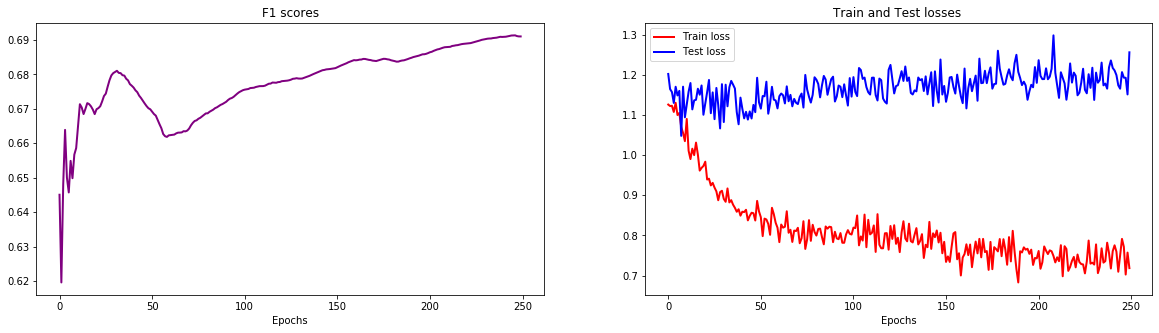

In [31]:
%run trainRNN_plot_utils.py
plot_one_input(F1_scores, trainLosses, testLosses, n_epoch)

In [32]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsEncoder_HBTRC_ANM.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )

Data saved into pickle.
